# Homework 2
Connor Blake

In [27]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## Problem 1

### a)

In [28]:
N = 7000
x = np.random.uniform(-3, 3, size=(N, 2)).astype(np.float32)
y = (np.sin(x[:, 0]) + np.sin(x[:, 1])).astype(np.float32).reshape(-1, 1)

x_tensor = torch.from_numpy(x)
y_tensor = torch.from_numpy(y)

dataset = TensorDataset(x_tensor, y_tensor)

### b)

In [29]:
class SingleHiddenNet(nn.Module):
    def __init__(self, hidden_dim=32, depth=1, activation="relu"):
        super().__init__()
        act = {"relu": nn.ReLU(), "sigmoid": nn.Sigmoid(), "tanh": nn.Tanh(), "gelu": nn.GELU()}[activation.lower()]
        layers = [nn.Linear(2, hidden_dim), act]
        for _ in range(depth - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), act])
        layers.append(nn.Linear(hidden_dim, 1))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)
    
model = SingleHiddenNet(hidden_dim=32, activation="relu")
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

### c)

In [30]:
epochs = 300

In [31]:
def plot_loss_curve(activation_function, hidden_dim=32, hidden_depth=1):

    train_losses, test_losses = [], []
    model = SingleHiddenNet(hidden_dim=hidden_dim, depth=hidden_depth, activation=activation_function)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_data, test_data = random_split(dataset, [train_size, test_size])

    batch_size = 256
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    for epoch in range(epochs):
        model.train()
        epoch_train = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            epoch_train += loss.item() * len(xb)
        epoch_train /= len(train_loader.dataset)

        model.eval()
        with torch.no_grad():
            epoch_test = sum(
                criterion(model(xb), yb).item() * len(xb) for xb, yb in test_loader
            ) / len(test_loader.dataset)

        train_losses.append(epoch_train)
        test_losses.append(epoch_test)
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="train")
    plt.plot(test_losses, label="test")
    plt.xlabel("epoch")
    plt.ylabel("MSE")
    plt.yscale("log")
    plt.legend()
    plt.title(f"Loss Curve, activation={activation_function}, hidden_dim={hidden_dim}, depth={hidden_depth}")
    plt.show()
    return model

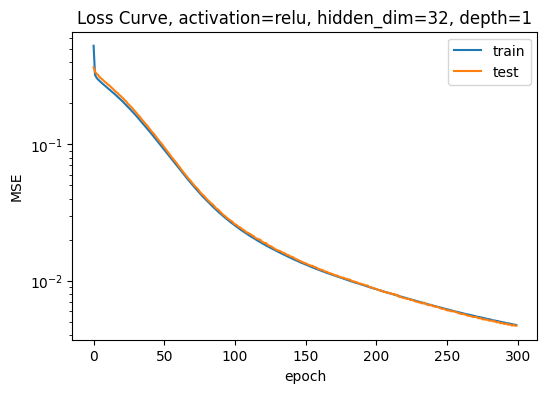

In [32]:
relu_model = plot_loss_curve("relu")

### d)

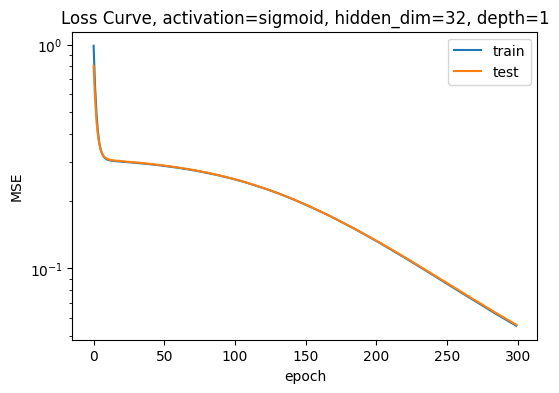

In [33]:
sigmoid_model = plot_loss_curve("sigmoid")

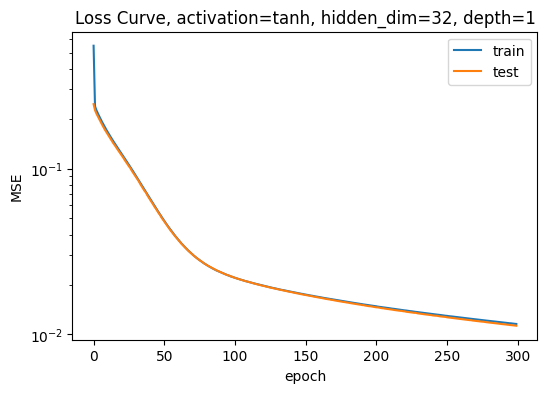

In [34]:
tanh_model = plot_loss_curve("tanh")

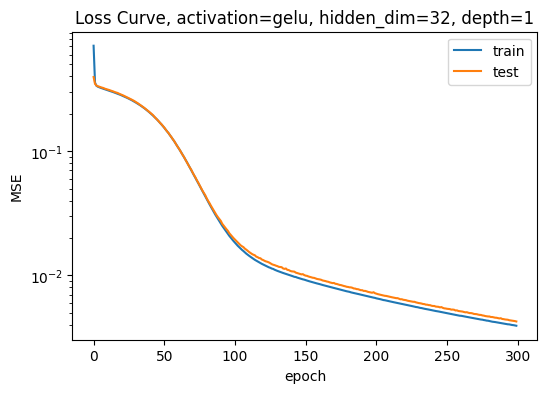

In [35]:
gelu_model = plot_loss_curve("gelu")

Gelu is the best model

### e)

In [36]:
def plot_contour_for_model(model, model_name):
    Nmesh = 200
    xs = np.linspace(-3, 3, Nmesh)
    X, Y = np.meshgrid(xs, xs)
    xt = torch.linspace(-3,3,Nmesh)
    Xt, Yt = torch.meshgrid(xt, xt, indexing="ij")
    torchgrid = torch.stack((Xt,Yt),dim=-1).reshape((-1,2))
    f_vals = np.sin(X) + np.sin(Y)
    with torch.no_grad():
        g_vals = model(torchgrid).reshape((Nmesh,Nmesh))
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    c1 = ax[0].contourf(X, Y, f_vals, levels=40)
    fig.colorbar(c1, ax=ax[0])
    ax[0].set_title("f(x,y) = sin(x) + sin(y)")
    c2 = ax[1].contourf(X, Y, g_vals, levels=40)
    fig.colorbar(c2, ax=ax[1])
    ax[1].set_title(f"{model_name} Model output g(x,y)")
    plt.show()

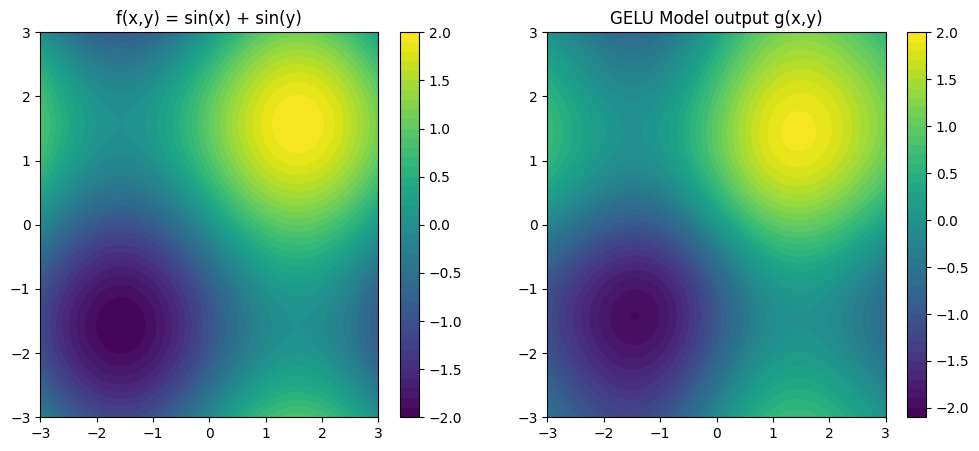

In [37]:
plot_contour_for_model(gelu_model, "GELU")

### f)

In [38]:
best_activation = "gelu"

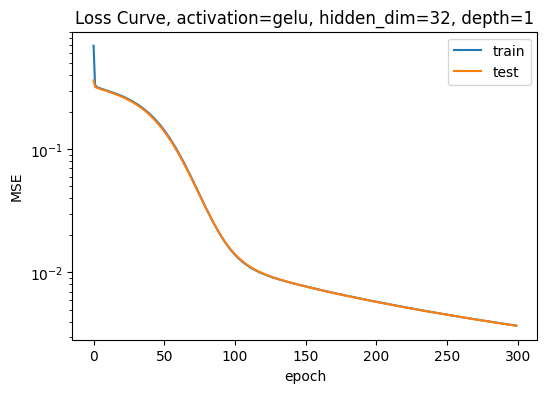

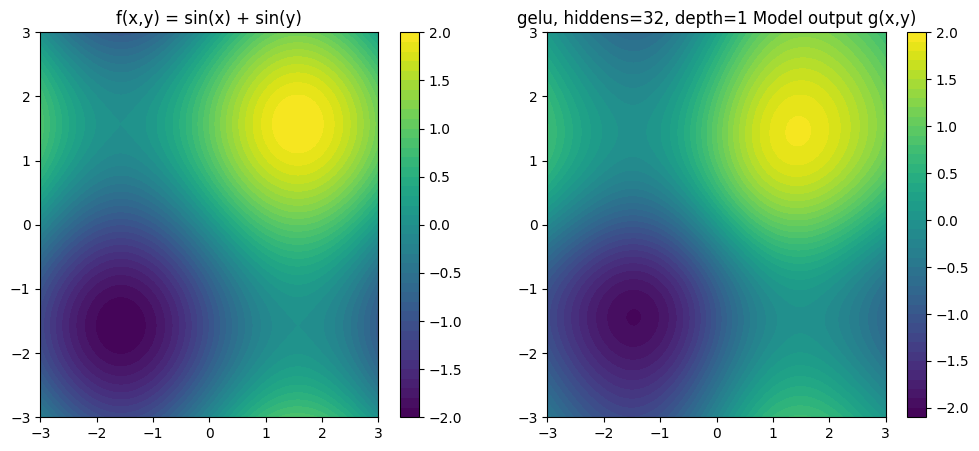

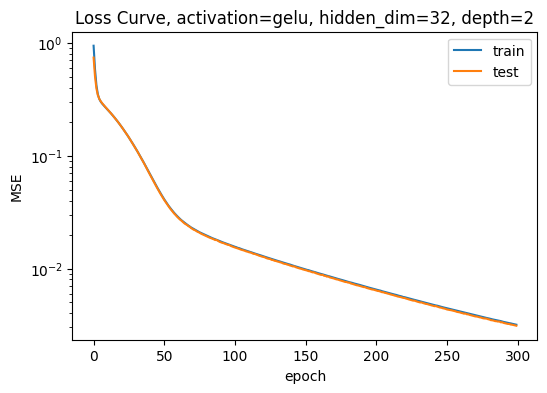

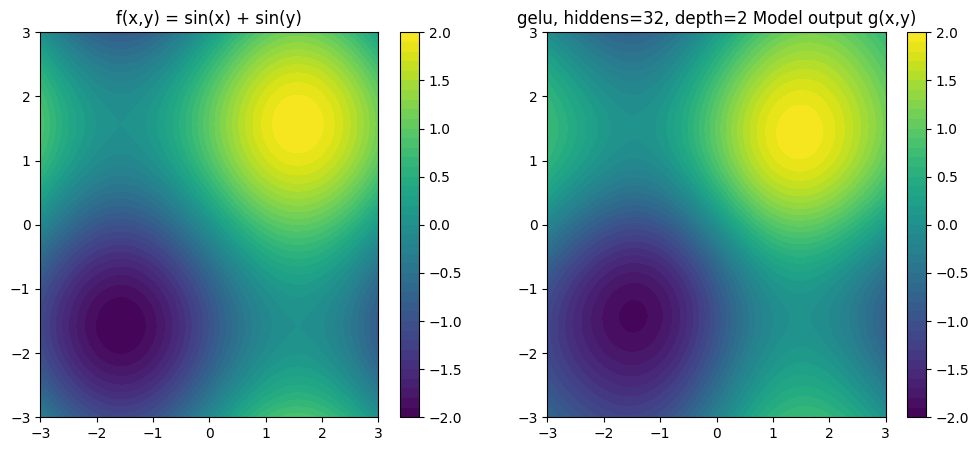

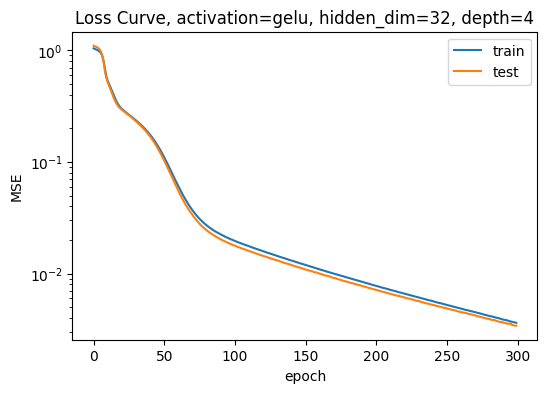

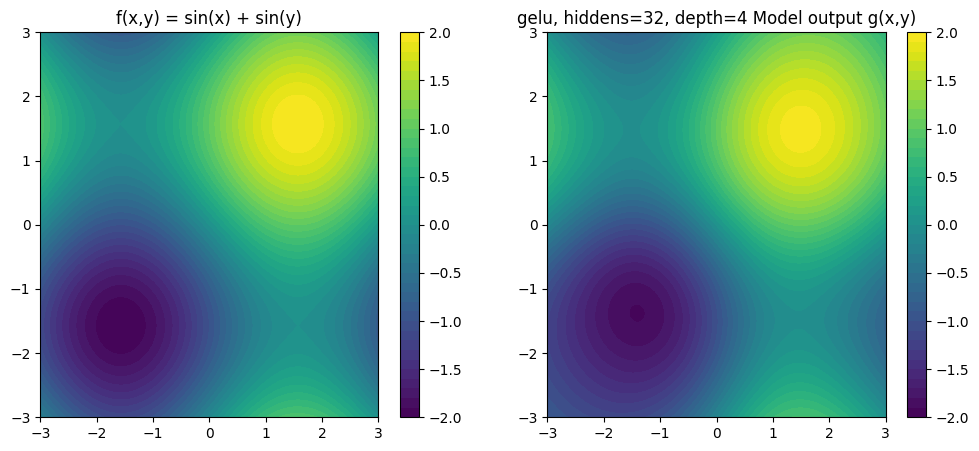

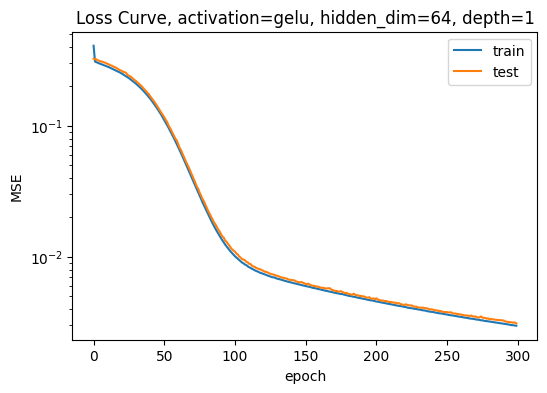

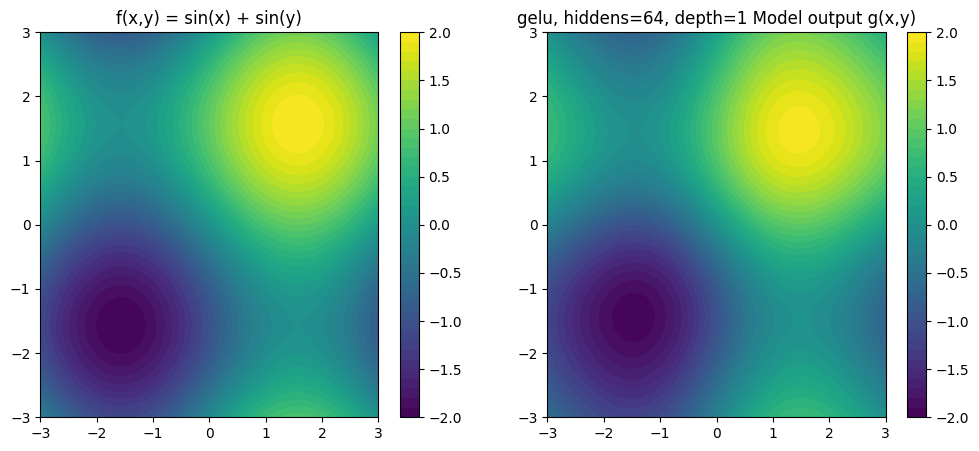

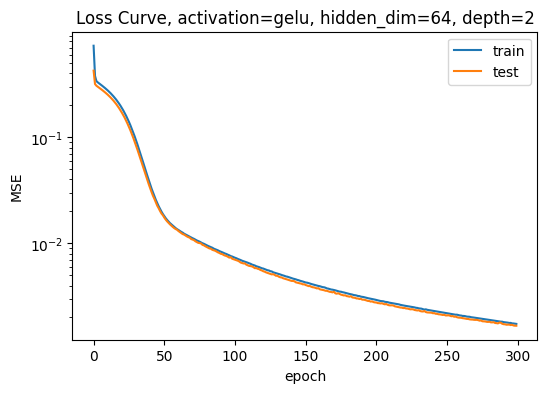

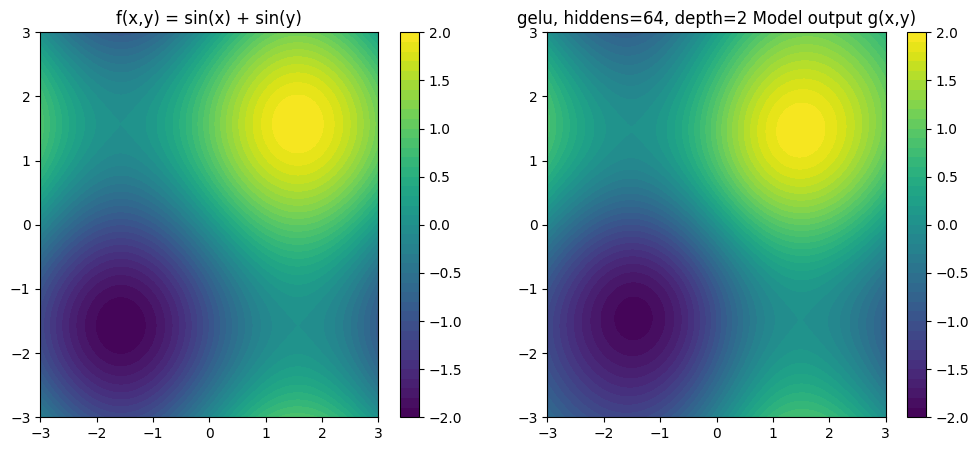

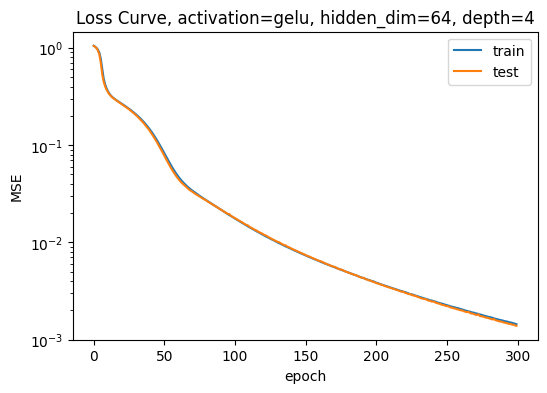

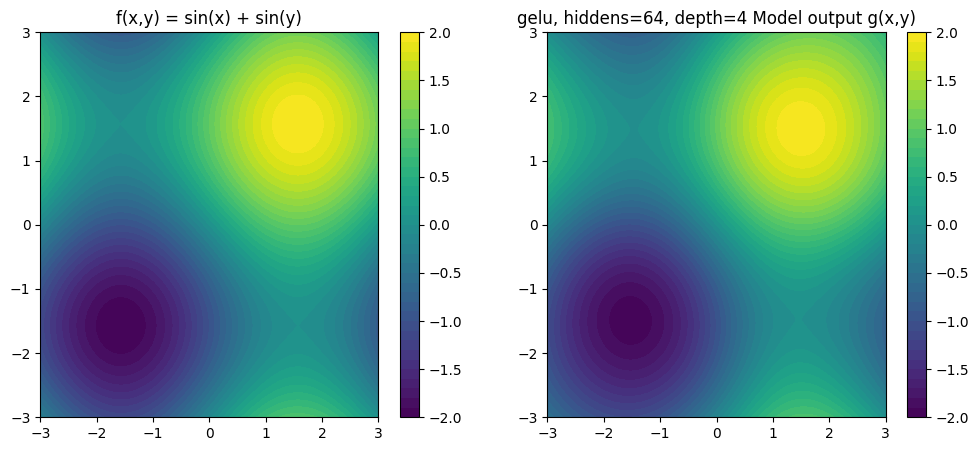

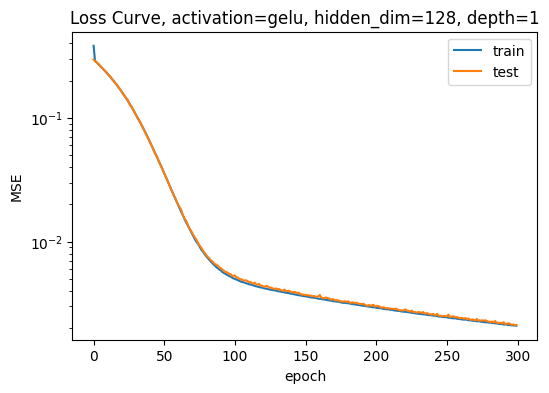

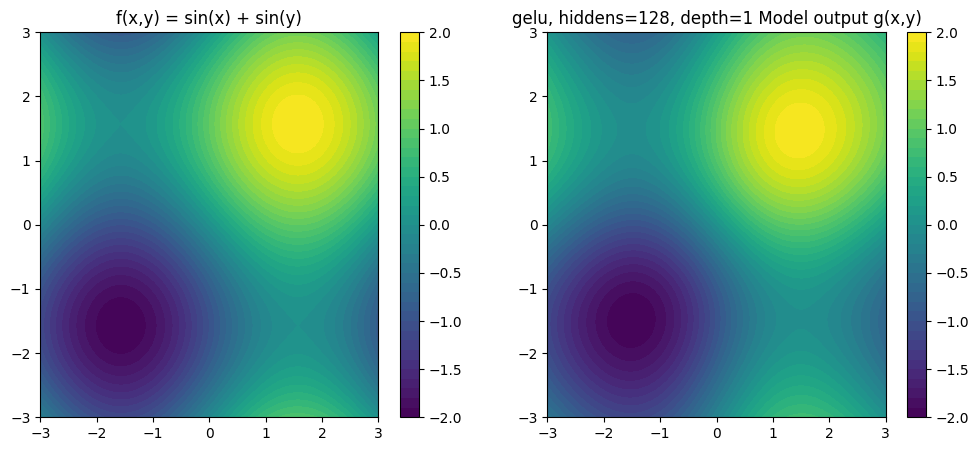

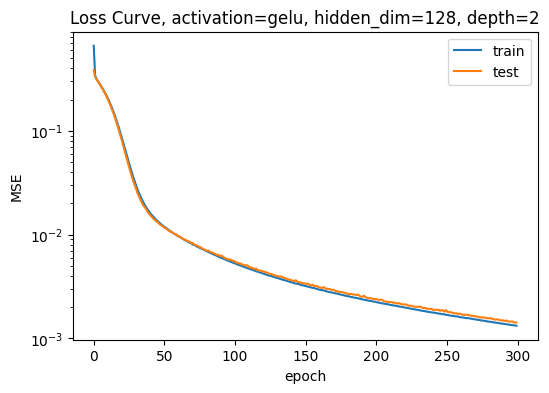

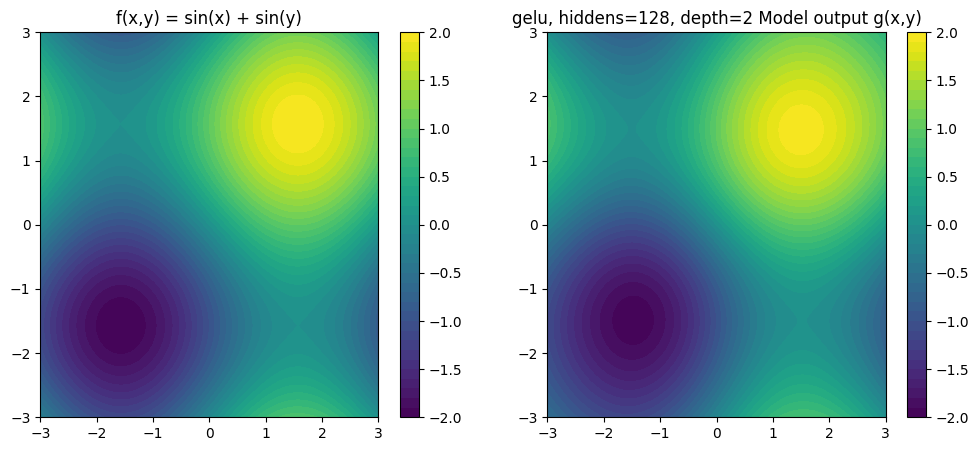

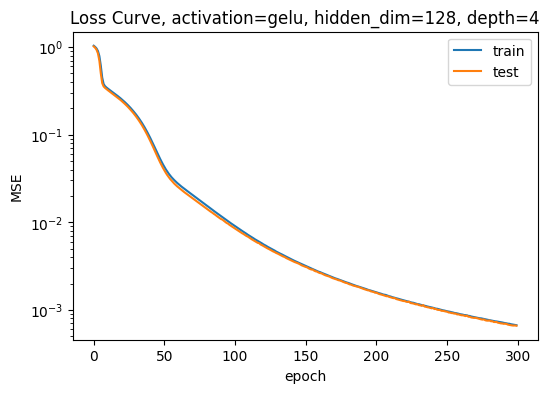

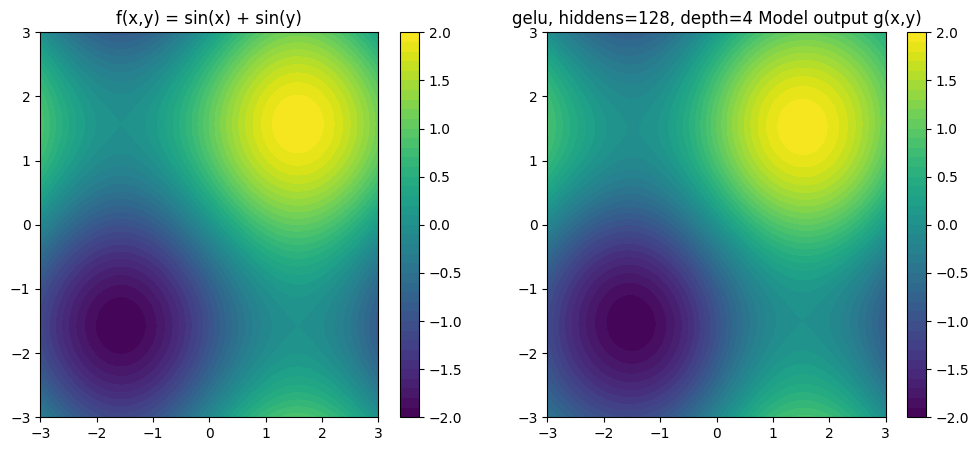

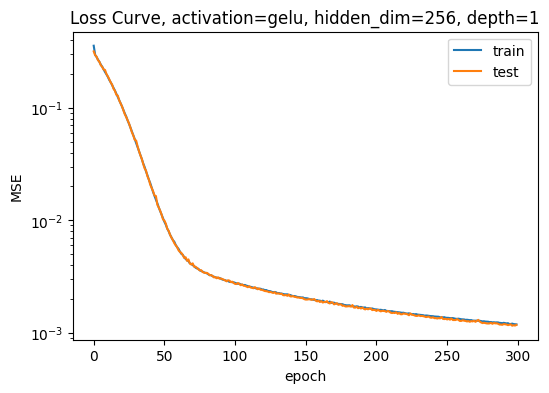

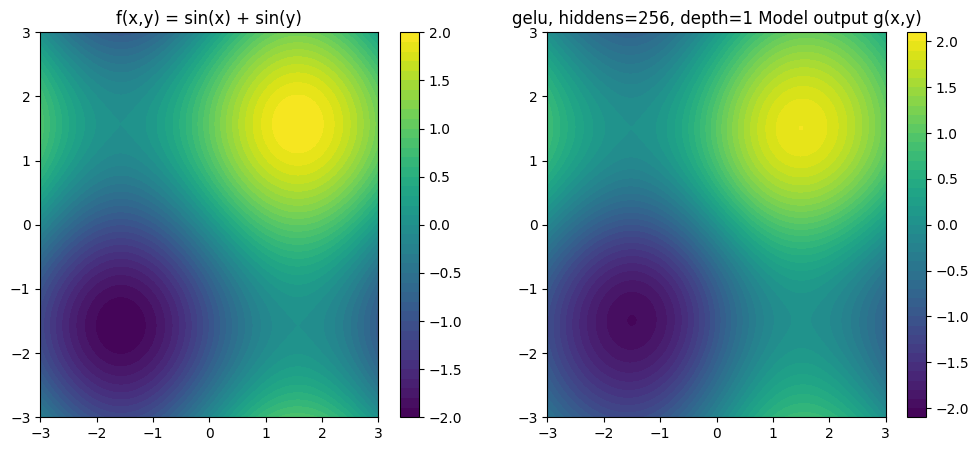

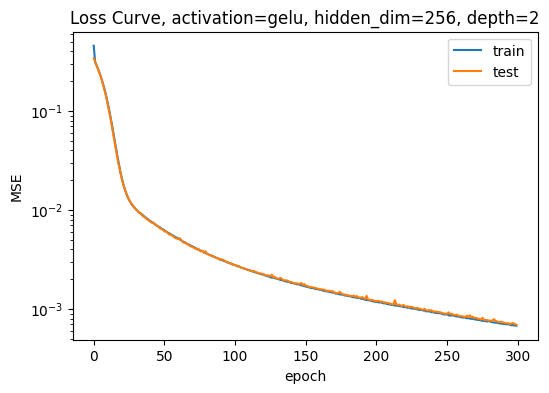

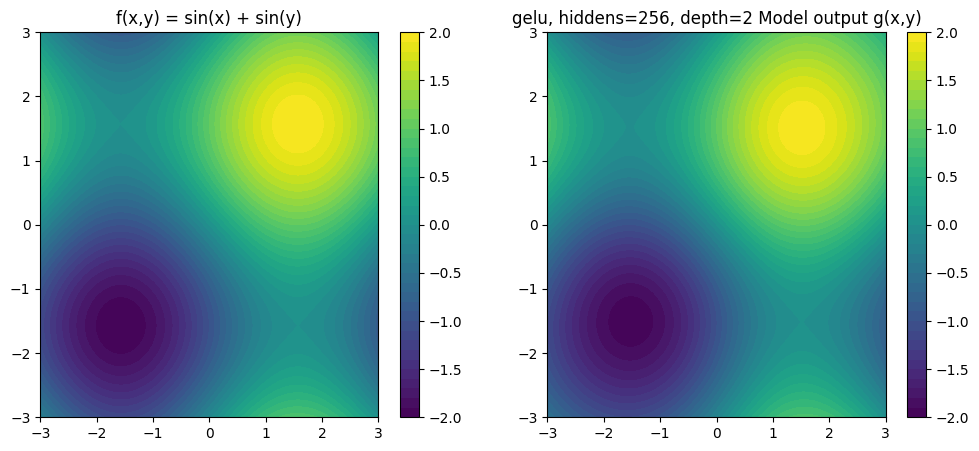

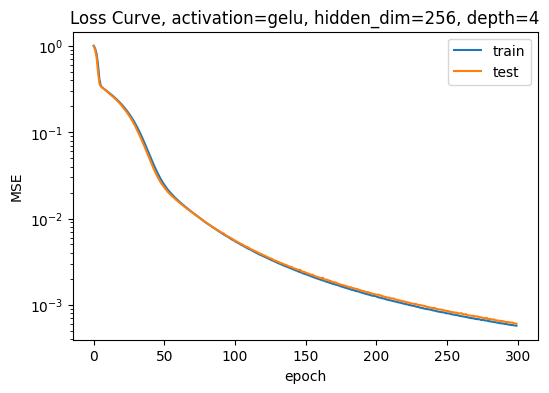

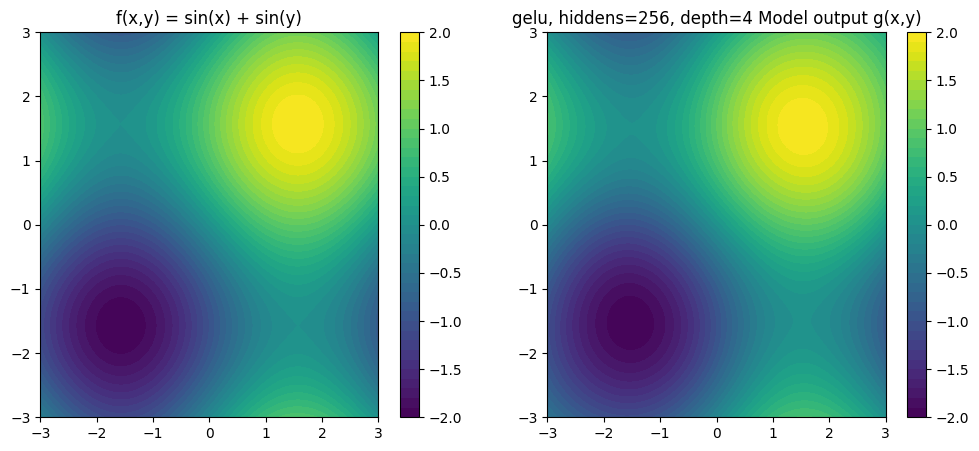

In [40]:
hidden_d = [32, 64, 128, 256]
hidden_layers = [1,2,4]
for hd in hidden_d:
    for hl in hidden_layers:
        dl_model = plot_loss_curve(best_activation,hidden_dim=hd,hidden_depth=hl)
        plot_contour_for_model(dl_model,best_activation + f", hiddens={hd}, depth={hl}")

## Problem 2

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch, torch.nn as nn, matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

### a)

In [44]:
sol_df = pd.read_csv("curated-solubility-dataset.csv")
print(sol_df.columns)


Index(['ID', 'Name', 'InChI', 'InChIKey', 'SMILES', 'Solubility', 'SD',
       'Ocurrences', 'Group', 'MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount',
       'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
       'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ',
       'BertzCT'],
      dtype='object')


### b)

In [45]:
features_start_at = list(sol_df.columns).index("MolWt")
X = sol_df.iloc[:, features_start_at:]
y = sol_df["Solubility"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### c)

In [60]:
X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test.values, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=64)

In [68]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dims=(128, 128), l2_lambda=0.0, activation="relu"):
        super().__init__()
        act = {"relu": nn.ReLU(), "gelu": nn.GELU(), "tanh": nn.Tanh(), "sigmoid": nn.Sigmoid()}[activation.lower()]
        layers, last = [], in_dim
        for h in hidden_dims:
            layers.extend([nn.Linear(last, h), act])
            last = h
        layers.append(nn.Linear(last, 1))
        self.net = nn.Sequential(*layers)
        self.l2_lambda = l2_lambda
    def forward(self, x):
        return self.net(x)
    def loss(self, pred, target):
        mse = nn.functional.mse_loss(pred, target)
        l2 = sum(p.pow(2).sum() for p in self.parameters())
        return mse + self.l2_lambda * l2

In [69]:
def execute_model(hidden_dims, l2_lambda, activation_fxn):
    model = MLP(in_dim=X_train.shape[1], hidden_dims=hidden_dims, l2_lambda=l2_lambda, activation=activation_fxn)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for _ in range(200):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            model.loss(model(xb), yb).backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(X_test_t).squeeze()
    rmse = torch.sqrt(torch.mean((preds - y_test_t.squeeze()) ** 2))
    actual = y_test_t.squeeze()
    return rmse.item(), actual, preds


In [70]:
def plot_model_eval(actual,preds, model_name):
    plt.figure(figsize=(5, 5))
    plt.scatter(actual, preds, alpha=0.7)
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], "k--",label="Perfect")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Solubility: actual vs predicted, Model={model_name}")
    plt.legend()
    plt.show()

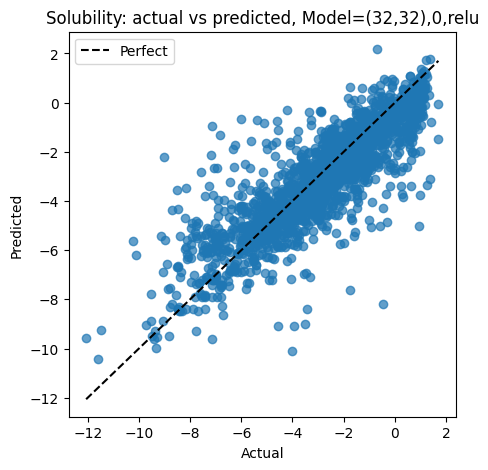

RMSE: 1.2636876106262207


In [72]:
rmse, actual,preds = execute_model(hidden_dims=(32,32),l2_lambda=0, activation_fxn="relu")
plot_model_eval(actual,preds,"(32,32),0,relu")
print("RMSE:",rmse)

In HW1, the RMSE for the linear model was 1.654, so this is a significant improvement.

### d)

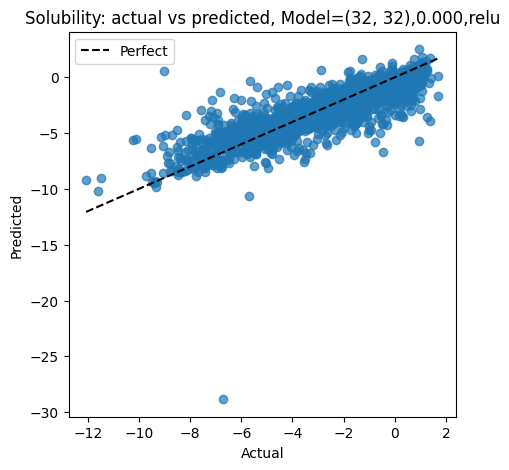

RMSE: 1.3137215375900269


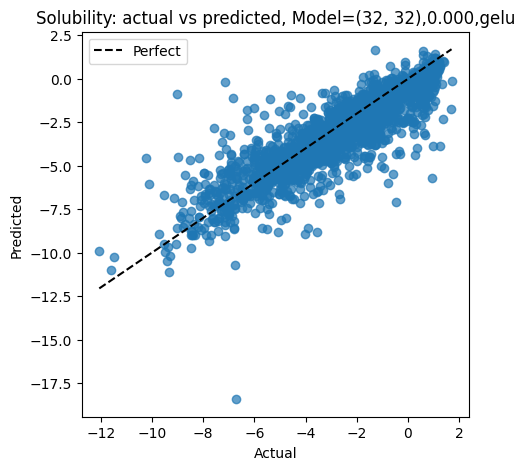

RMSE: 1.2696990966796875


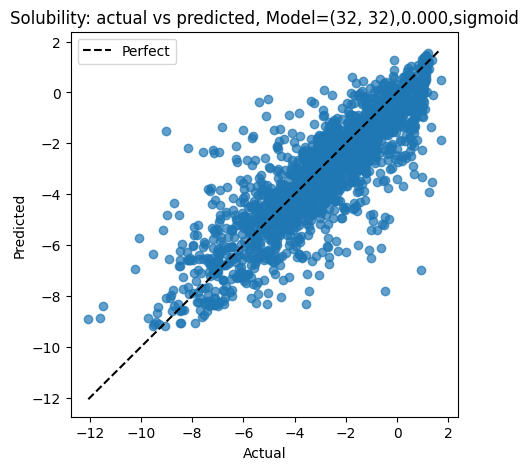

RMSE: 1.3101806640625


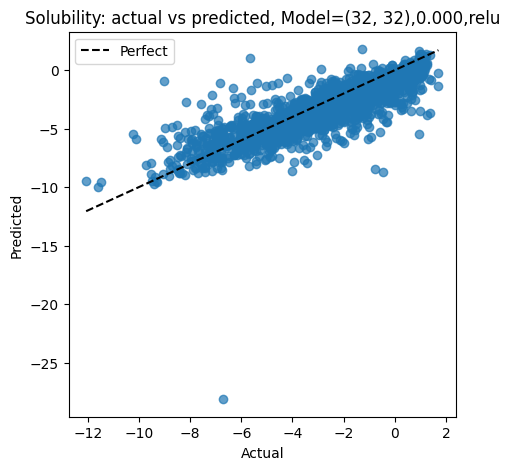

RMSE: 1.412887692451477


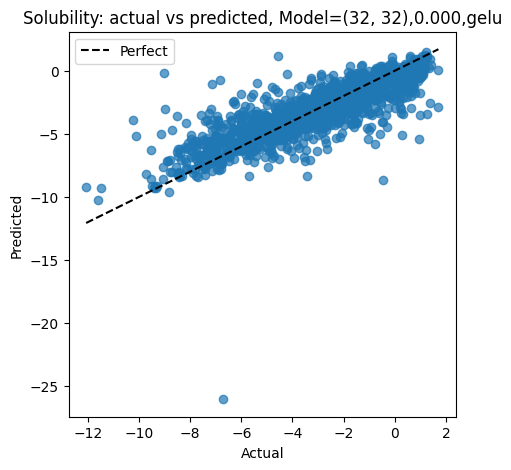

RMSE: 1.2847378253936768


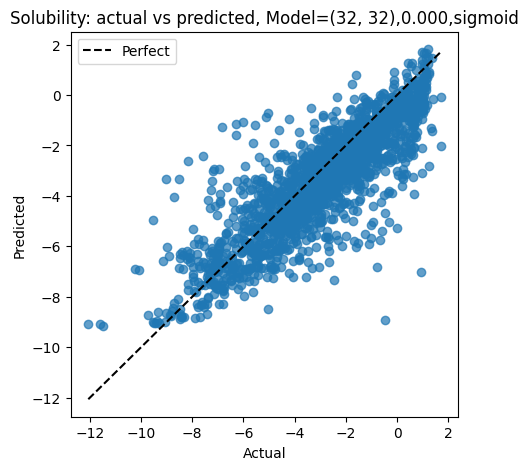

RMSE: 1.3331886529922485


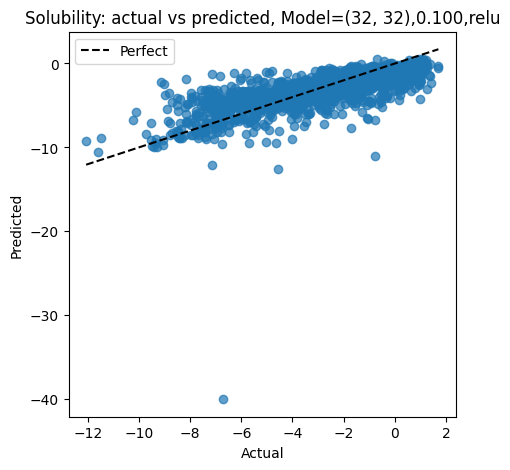

RMSE: 1.6722087860107422


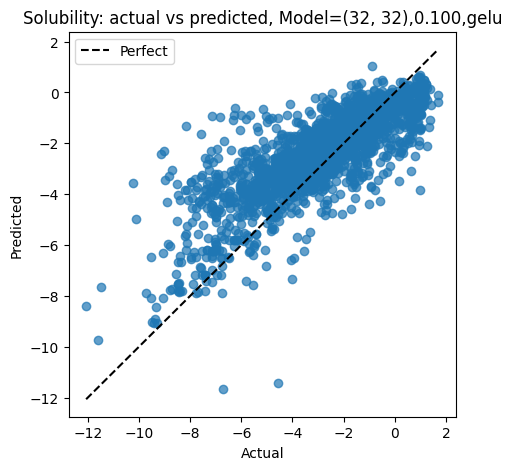

RMSE: 1.5119071006774902


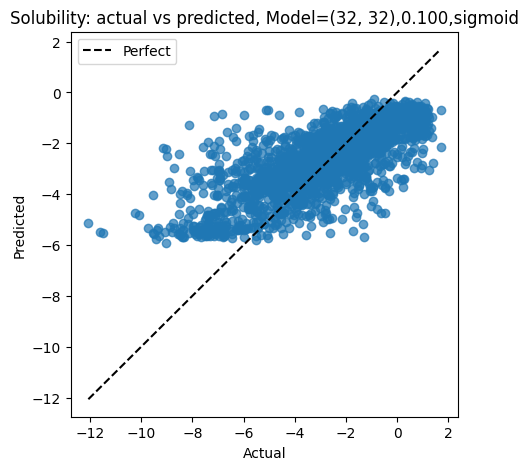

RMSE: 1.6665247678756714


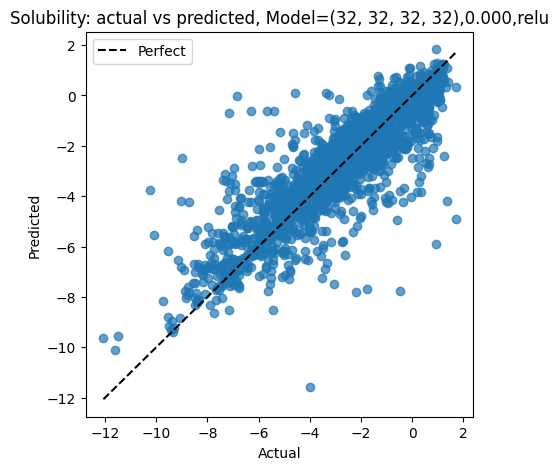

RMSE: 1.2064473628997803


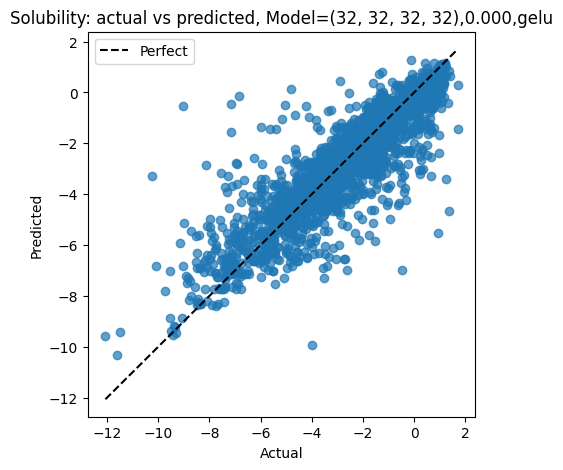

RMSE: 1.201561450958252


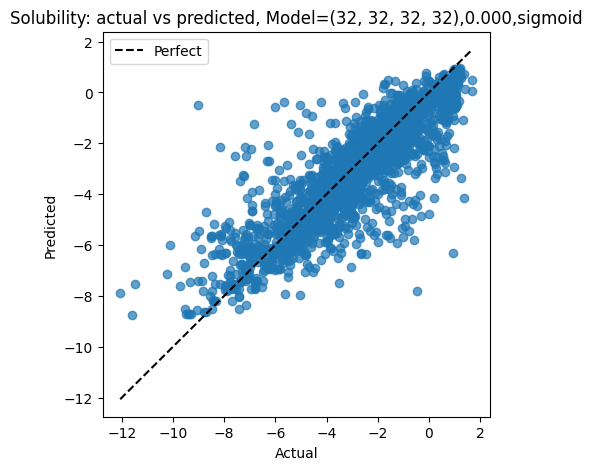

RMSE: 1.298999547958374


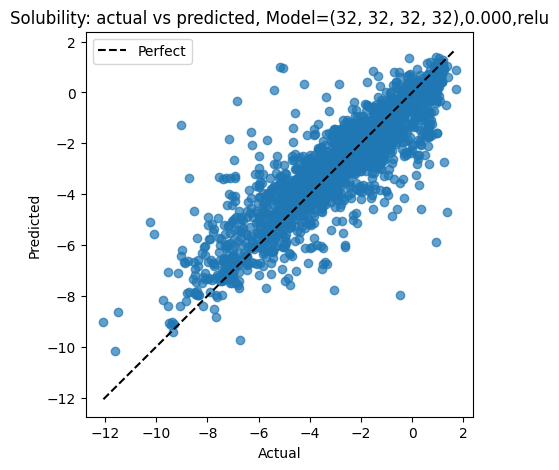

RMSE: 1.1847447156906128


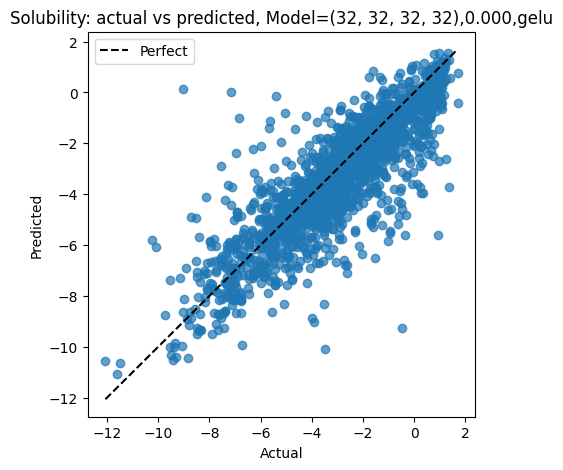

RMSE: 1.2904706001281738


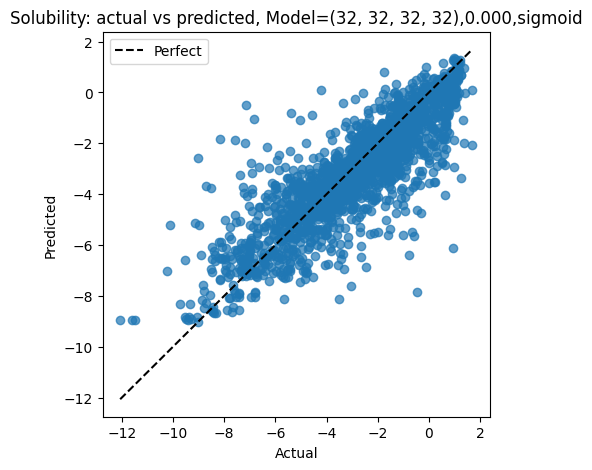

RMSE: 1.2797335386276245


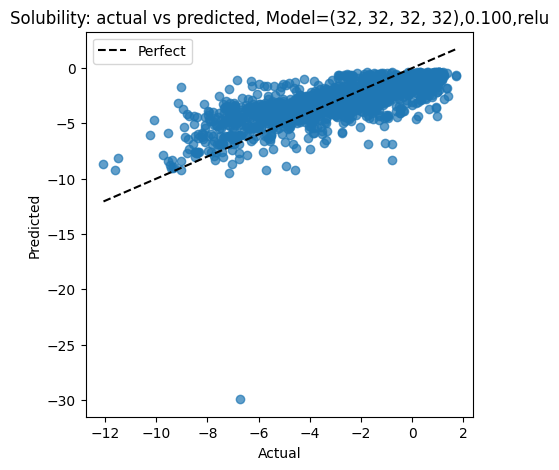

RMSE: 1.5867477655410767


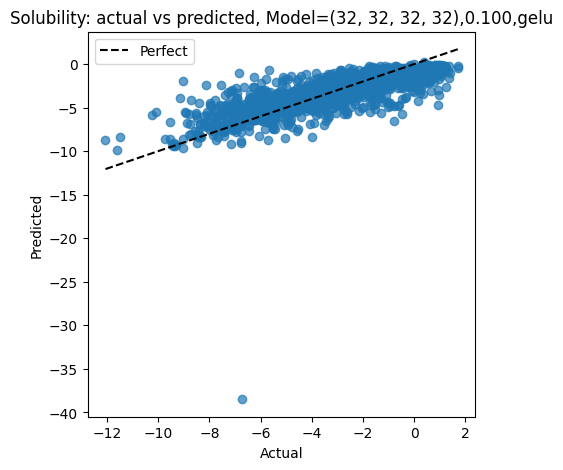

RMSE: 1.5046478509902954


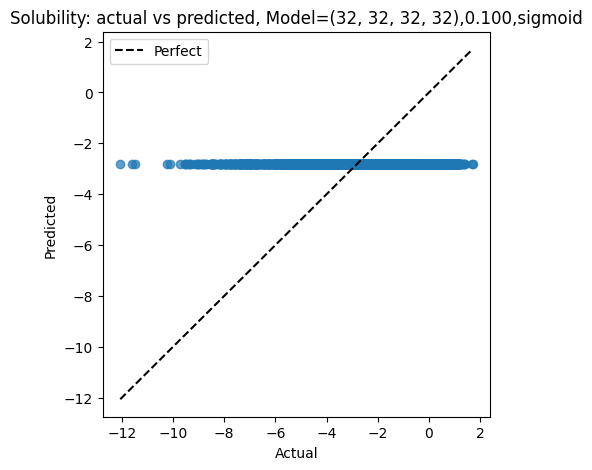

RMSE: 2.349642276763916


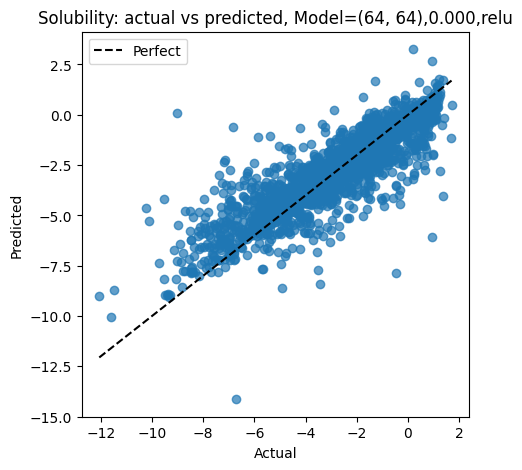

RMSE: 1.2035832405090332


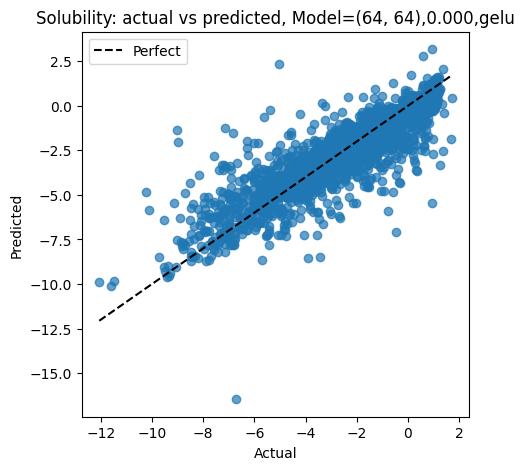

RMSE: 1.2346339225769043


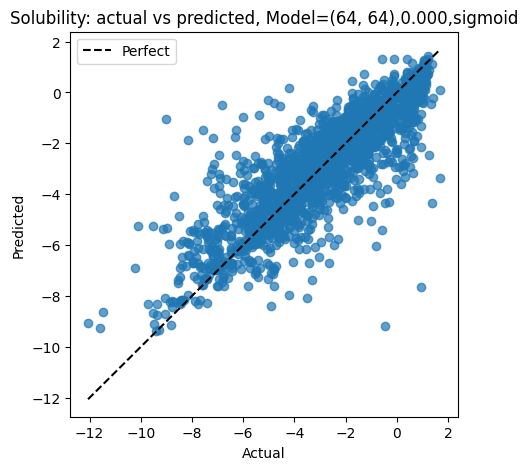

RMSE: 1.2920434474945068


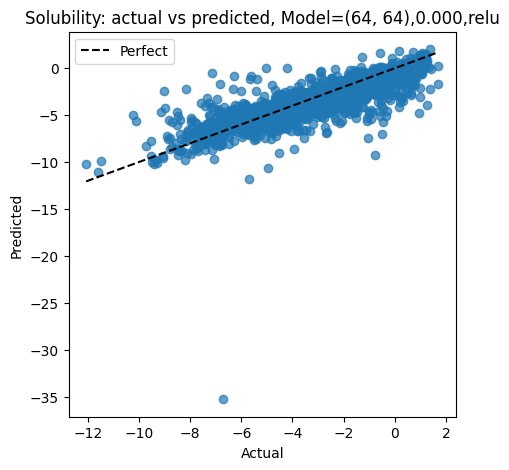

RMSE: 1.4542958736419678


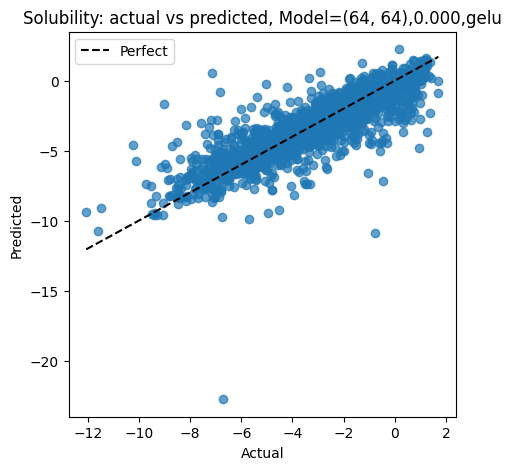

RMSE: 1.2628434896469116


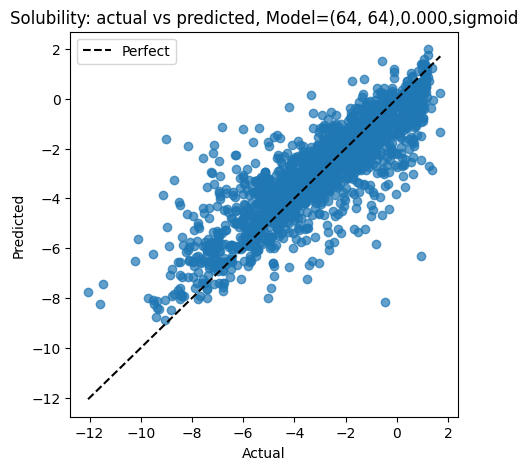

RMSE: 1.2503337860107422


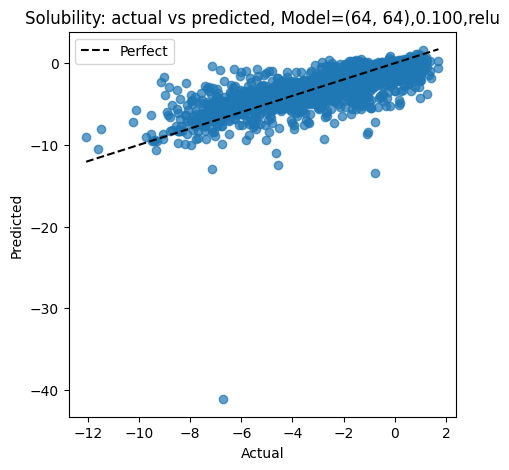

RMSE: 1.7404048442840576


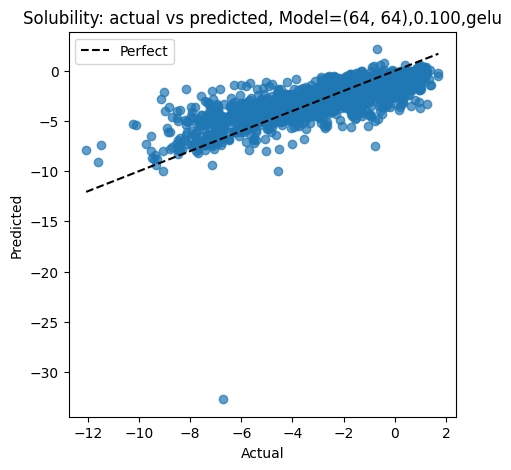

RMSE: 1.5252127647399902


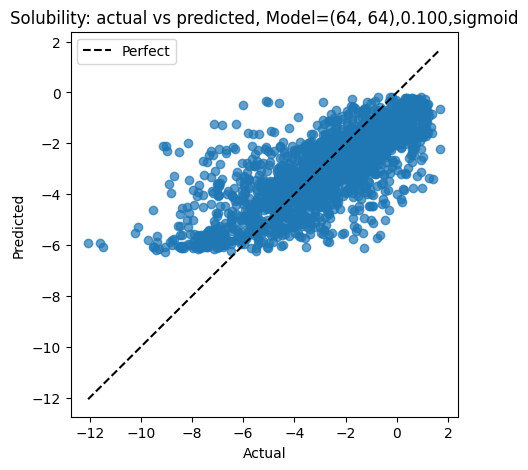

RMSE: 1.6228958368301392


TypeError: 'int' object is not iterable

In [73]:
for shape in [(32,32,32,32),(64,64,64),(128,128,128)]:
    for l2_lambda in [0,1e-4,1e-1]:
        for activation in ["relu","gelu","sigmoid"]:
            rmse, actual,preds = execute_model(hidden_dims=shape,l2_lambda=l2_lambda, activation_fxn=activation)
            plot_model_eval(actual,preds,str(shape)+f",{l2_lambda:.4f},"+activation)
            print("RMSE:",rmse)

Unsurprisingly, high amounts of regularization degraded the models, deeper models performed better, and RELU/GELU were the best activation functions (sigmoid would be limited to 1, and we're not classifying here)

## Problem 3

In [ ]:
with np.load("solubility.npz") as r:
    pos_data, neg_data = r["positives"], r["negatives"]